In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!
✨🍰✨ Everything looks OK!


In [2]:
%%capture
!conda install -c conda-forge openmm mdtraj parmed py3dmol
#install openabc for single bead per aminoacid CG models
#https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011442
#https://github.com/ZhangGroup-MITChemistry/OpenABC
!pip install openabc

In [4]:
# allow widgets in colab
from google.colab import output
output.enable_custom_widget_manager()
#check openmm installation
#!python -m openmm.testInstallation

In [5]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj
import py3Dmol
import sys
try:
    import openmm as mm
    import openmm.app as app
    import openmm.unit as unit
except ImportError:
    import simtk.openmm as mm
    import simtk.openmm.app as app
    import simtk.unit as unit

sys.path.append('../../')

# load HPS model with OpenABC
from openabc.forcefields.parsers import HPSParser
from openabc.forcefields import HPSModel
from openabc.utils.helper_functions import build_straight_CA_chain, write_pdb, compute_rg
from openabc.lib import *

In [6]:
# set simulation platform
platform_name = 'CUDA'   # CPU or CUDA

In [7]:
# sequences studied in original HPS paper by Dignon et al. https://doi.org/10.1371/journal.pcbi.1005941
CspTm = 'GPGMRGKVKWFDSKKGYGFITKDEGGDVFVHWSAIEMEGFKTLKEGQVVEFEIQEGKKGGQAAHVKV'
IN = 'GSHCFLDGIDKAQEEHEKYHSNWRAMASDFNLPPVVAKEIVASCDKCQLKGEAMHGQVDC'
ProTaN = 'GPSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGEQEADNEVDEECEEGGEEEEEEEEGDGEEEDGDEDEEAESATGKRAAEDDEDDDVDTKKQKTDEDD'
ProTaC = 'MAHHHHHHSAALEVLFQGPMSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNANEENGEQEADNEVDEECEEGGEEEEEEEEGDGEEEDGDEDEEAESATGKRAAEDDEDDDVDTKKQKTDEDD'
R15 = 'KLKEANKQQNFNTGIKDFDFWLSEVEALLASEDYGKDLASVNNLLKKHQLLEADISAHEDRLKDLNSQADSLMTSSAFDTSQVKDKRETINGRFQRIKSMAAARRAKLNESHRL'
R17 = 'RLEESLEYQQFVANVEEEEAWINEKMTLVASEDYGDTLAAIQGLLKKHEAFETDFTVHKDRVNDVAANGEDLIKKNNHHVENITAKMKGLKGKVSDLEKA'
hCyp = 'SSFHRIIPGFMSQGGDFTRHNGTGGKSIYGEKFEDENFILKHTGPGILSMANAGPNTNGSQFFISTAKTEFLDGKHVVFGKVKEGMNIVEAMERFGSRNGKTSKKITIADSGQLE'
ProteinL = 'MEEVTIKANLIFANGSTQTAEFKGTFEKATSEAYAYADTLKKDNGEWTVDVADKGYTLNIKFAG'
ACTR = 'GTQNRPLLRNSLDDLVGPPSNLEGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPKQD'
hNHE1cdt = 'MVPAHKLDSPTMSRARIGSDPLAYEPKEDLPVITIDPASPQSPESVDLVNEELKGKVLGLSRDPAKVAEEDEDDDGGIMMRSKETSSPGTDDVFTPAPSDSPSSQRIQRCLSDPGPHPEPGEGEPFFPKGQ'
sNase = 'ATSTKKLHKEPATLIKAIDGDTVKLMYKGQPMTFRLLLVDTPETKHPKKGVEKYGPEASAFTKKMVENAKKIEVEFDKGQRTDKYGRGLAYIYADGKMVNEALVRQGLAKVAYVYKPNNTHEQHLRKSEAQAKKEK'
alphasynuclein = 'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSE EGYQDYEPEA'


In [8]:
sequence = CspTm
ca_pdb = 'init.pdb'
ca_atoms = build_straight_CA_chain(sequence, r0=0.38)
write_pdb(ca_atoms, ca_pdb)
protein_parser = HPSParser(ca_pdb)
protein = HPSModel()
protein.append_mol(protein_parser)

Parse molecule with default settings.


In [9]:
top = app.PDBFile(ca_pdb).getTopology()
init_coord = app.PDBFile(ca_pdb).getPositions()
protein.create_system(top, box_a=100, box_b=100, box_c=100)
protein.add_protein_bonds(force_group=1)
#KR HPS scale as in original Dignon et al. HPS paper.
protein.add_contacts('KR', mu=1, delta=0, force_group=2)
#Used in OpenABC example: protein.add_contacts('Urry', mu=1, delta=0.08, force_group=2)
#Default Debye screening length = 1 nm (~ 100 mM ionic strength) ; dielectric constant = 80
protein.add_dh_elec(force_group=3)
temperature = 300*unit.kelvin
friction_coeff = 1/unit.picosecond
timestep = 10*unit.femtosecond
integrator = mm.LangevinMiddleIntegrator(temperature, friction_coeff, timestep)
protein.set_simulation(integrator, platform_name, init_coord=init_coord)

Add protein bonds.
Add nonbonded contacts.
Use KR hydropathy scale.
Scale factor mu = 1 and shift delta = 0.
Add Debye-Huckel electrostatic interactions.
Set Debye length as 1 nm.
Set water dielectric as 80.0.
Use platform: CUDA
Use precision: mixed


In [10]:
%%capture
protein.simulation.minimizeEnergy()
output_interval = 1000 # measused in number of timesteps: 1000 steps = 10 ps for timestep = 10 fs
nanosec = 100000 # measured in number of timesteps: 100000 steps = 1 ns for timestep = 10 fs
output_dcd = 'output.dcd'
protein.add_reporters(output_interval, output_dcd)
protein.simulation.context.setVelocitiesToTemperature(temperature)
protein.simulation.step(int(100*nanosec))

In [11]:
# visualize specific frame of trajectory
frame_number = 400
traj = mdtraj.load_dcd('output.dcd', top=ca_pdb)
frame = traj[frame_number]
#frame = traj  # to visualize whole trajectorie as movie
frame.save_pdb('frame.pdb')
view = py3Dmol.view(width=400, height=400)
view.addModelsAsFrames(open('frame.pdb', 'r').read(),'pdb')
view.setBackgroundColor('white')

# Colorschemes https://3dmol.csb.pitt.edu/doc/global.html#builtinColorSchemes
#view.setStyle({'sphere': {'color':'green'}})  # same color
#view.setStyle({'sphere':{'colorscheme':{'prop':'resi','gradient':'roygb','min':26,'max':109}}})  # gradient color
view.setStyle({'sphere': {'colorscheme':'amino'}})  # amino acid color
#view.setStyle({'sphere': {'colorscheme':'shapely'}})  # amino acid color
view.zoomTo()
#view.zoomTo({'model':-1})
#view.animate({'loop': "forward", 'interval': 1000})  # for movies
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
# define function to create list of aminoacid masses
def build_mass_array(sequence):
    ''' Build a mass array with given sequence.
    '''
    # masses copied from OpenABC github functions
    mass_dict={'ALA': 71.08, 'ARG': 156.2, 'ASN': 114.1, 'ASP': 115.1, 'CYS': 103.1, 'GLN': 128.1, 'GLU': 129.1,
               'GLY': 57.05, 'HIS': 137.1, 'ILE': 113.2, 'LEU': 113.2, 'LYS': 128.2, 'MET': 131.2,
               'PHE': 147.2, 'PRO': 97.12, 'SER': 87.08, 'THR': 101.1, 'TRP': 186.2, 'TYR': 163.2, 'VAL': 99.07}

    n_atoms = len(sequence)
    data = np.zeros(n_atoms)
    for i in range(n_atoms):
        resname = protein_lib._amino_acid_1_letter_to_3_letters_dict[sequence[i]]
        data[i] = mass_dict[resname]

    return data


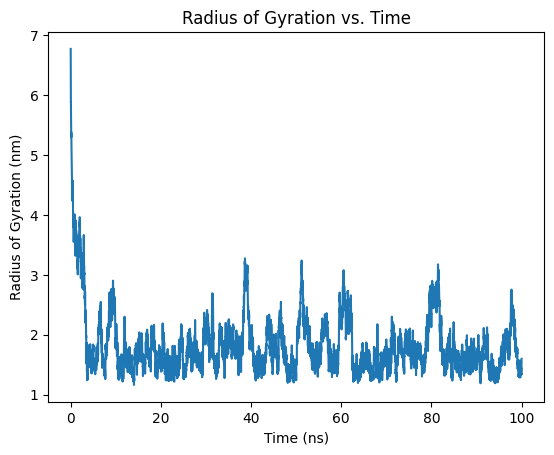

In [13]:
masses = build_mass_array(sequence)
# make a plot of Rg vs time
# MDtraj page: https://www.mdtraj.org/1.9.8.dev0/index.html
rg = mdtraj.compute_rg(traj, masses)  # masses = None assumes all aminoacids have same mass
# rg = compute_rg(traj,masses)  # OpenABC has a helper Rg function too. Haven't tested
timearray = np.arange(len(rg))*output_interval/nanosec
plt.plot(timearray,rg)
plt.xlabel('Time (ns)')
plt.ylabel('Radius of Gyration (nm)')
plt.title('Radius of Gyration vs. Time')
plt.show()

In [23]:
# Calculate the average Rg after equilibration time
equilibration_time = 2 # ns
equilibration_time_steps = int(equilibration_time*nanosec/output_interval)
average_rg = np.mean(rg[equilibration_time_steps:])
average_rg

1.6005131799764047